In [14]:
import rasterio as rio
from rasterio.plot import show
from rasterio import mask
from rasterio.rio import stack
from rasterio.features import shapes
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import merge

import numpy as np
import shutil
import geopandas as gpd

import boto3
import s3fs
from IPython import display
import skimage
from sklearn import metrics


from shapely import geometry
from shapely import ops
import json

from tempfile import mkdtemp

import supermercado
import mercantile

from io import BytesIO
import base64

import mercantile
from tqdm import tqdm

import sys
sys.path.append("../model/robosat_pink/")
from robosat_pink import datasets

from shapely import geometry
from functools import partial
import pyproj
from shapely.ops import transform

import re
import os 
from glob import glob
os.environ['CURL_CA_BUNDLE']='/etc/ssl/certs/ca-certificates.crt'

import matplotlib.pyplot as plt
%matplotlib inline

# Analysis of Accuracy of Predictions

In [2]:
aws_session = boto3.Session(profile_name = 'esip')

**Scope**: Predictions from a single ASO collect from Tuolumne, 20180528. 

In [3]:
fs = s3fs.S3FileSystem(session = aws_session)
predictions =  [d.split('/')[1] for d in fs.ls('planet-snowcover-predictions') if re.match(".*20180528.*_clip", d)]

We'll pair these predictions with ASO.

In [4]:
aso = datasets.S3SlippyMapTiles("s3://planet-snowcover-snow/{}".format("ASO_3M_SD_USCATE_20180528_binary"), mode='multibands', aws_profile='esip')
display.Markdown("{} ASO Tiles".format(len(aso)))

1983 ASO Tiles

In [5]:
predictions

['20180528_180846_1002_3B_AnalyticMS_SR_clip',
 '20180528_180847_1002_3B_AnalyticMS_SR_clip',
 '20180528_181107_1025_3B_AnalyticMS_SR_clip',
 '20180528_181108_1025_3B_AnalyticMS_SR_clip',
 '20180528_181109_1025_3B_AnalyticMS_SR_clip',
 '20180528_181110_1025_3B_AnalyticMS_SR_clip',
 '20180528_181111_1025_3B_AnalyticMS_SR_clip',
 '20180528_181112_1025_3B_AnalyticMS_SR_clip',
 '20180528_181113_1025_3B_AnalyticMS_SR_clip',
 '20180528_181114_1025_3B_AnalyticMS_SR_clip',
 '20180528_181115_1025_3B_AnalyticMS_SR_clip',
 '20180528_181116_1025_3B_AnalyticMS_SR_clip',
 '20180528_181319_1005_3B_AnalyticMS_SR_clip',
 '20180528_181320_1005_3B_AnalyticMS_SR_clip',
 '20180528_181322_1005_3B_AnalyticMS_SR_clip',
 '20180528_181323_1005_3B_AnalyticMS_SR_clip',
 '20180528_181324_1005_3B_AnalyticMS_SR_clip',
 '20180528_181325_1005_3B_AnalyticMS_SR_clip',
 '20180528_181326_1005_3B_AnalyticMS_SR_clip',
 '20180528_181327_1005_3B_AnalyticMS_SR_clip']

In [6]:
def plot3(image, pred, mask, tile, ax = None):
#     fig.suptitle(tile)
    ax[0].imshow(image)
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    ax[0].set_title("RGB (Planet, ~3m)")

    #     ax[0].set_title(tile)
    ax[1].imshow(mask)
    ax[1].set_title('ASO Observation')
    ax[1].set_xticklabels([])
    ax[1].set_yticklabels([])
#     ax[1].set_title("mask")
    ax[2].imshow(pred, cmap='cividis')#, vmin = 0, vmax = )
    ax[2].set_title("ML Prediction")
    ax[2].set_xticklabels([])
    ax[2].set_yticklabels([])
#     ax[2].set_title('prediction')
#     ax[3].imshow((pred > 0.0) - mask, cmap='seismic')

#     ax[2].set_title(mets
    ax[3].imshow(mask - pred, cmap='bwr')
    ax[3].set_title("Mask - Pred")
    ax[3].set_xticklabels([])
    ax[3].set_yticklabels([])
        

#     plt.colorbar(diff, ax = ax[3])
    # NDSI = 1-4 / 1 + 4
#    plt.colorbar(pred, ax  = ax[2], orientation='horizontal')


In [7]:
htmlTemplate = """
<!doctype html>

<html lang="en">
<head>
  <meta charset="utf-8">

  <title>{source}</title>

</head>

<body>
<h2>Source Image: {source}</h2>
<h2>Mean F1 (no zero tiles): {f1}</h2>
<h2>Mean Accuracy: {acc}</h2>
{content}
</body>
</html>
"""
imgTemplate =  '<p><img src=\'data:image/png;base64,{}\'></p>'


In [134]:
encodedImages = []
f1_scores = []
acc_scores = []
TNs, FNs, TPs, FPs = [], [], [], []
for pred in predictions[8:]:
    pred_tiles = datasets.S3SlippyMapTiles("s3://planet-snowcover-predictions/"+pred, 'multibands', aws_profile='esip', ext='tif') ## only TIF predictions wanted here.
    image_tiles = datasets.S3SlippyMapTiles("s3://planet-snowcover-imagery/"+pred, 'multibands', aws_profile='esip')
    print(len(pred_tiles))
    for p_t, i_t in tqdm(zip(pred_tiles, image_tiles), total = len(pred_tiles)):
        tile = p_t[0]
        asoTileLoc = "s3://planet-snowcover-snow/{}/{}/{}/{}.tif".format("ASO_3M_SD_USCATE_20180528_binary", tile.z, tile.x, tile.y)
        try: 
            with rio.Env(profile_name='esip'):
                asoTile = rio.open(asoTileLoc)
        except rio.RasterioIOError as e: 
            print(e)
            continue
        fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))
        rgb = np.moveaxis(i_t[1][[2, 1, 0]].numpy(), 0, 2)
        rgb = skimage.exposure.rescale_intensity(skimage.exposure.equalize_adapthist(rgb), in_range = (0, .62))
        plot3(rgb, p_t[1].squeeze().numpy(), asoTile.read().squeeze(), tile, ax)
       
        aso_pix = asoTile.read().squeeze().flatten()
        aso_all_zero = (aso_pix == 0).all()
        pred_pix = p_t[1].squeeze().flatten().numpy().astype(aso_pix.dtype)

        f1 = metrics.f1_score(aso_pix, pred_pix)
        acc = metrics.accuracy_score(aso_pix, pred_pix)
        f1_scores.append((f1, aso_all_zero))
        acc_scores.append(acc)
                         
        fig.suptitle("{}, F1: {:.2f} Acc: {:.2f}".format(tile, f1, acc))

        tmpfile = BytesIO()
        fig.savefig(tmpfile, format='png', bbox_inches='tight')     
        encoded = base64.b64encode(tmpfile.getvalue())
        encodedImages.append(encoded)
        plt.close()
        
        CM = metrics.confusion_matrix(aso_pix, pred_pix)
        
        if CM.shape != (2,2): continue

        TNs.append(CM[0][0])
        FNs.append(CM[1][0])
        TPs.append(CM[1][1])
        FPs.append(CM[0][1])
        
    break

123


In [8]:
imgTags = [imgTemplate.format(e.decode('utf-8')) for e in encodedImages]

In [12]:
f1_score_nozero = np.mean([f[0] for f in f1_scores if not f[1]])
mean_acc = np.mean(acc_scores)

In [13]:
predictions[8]

'20180528_181113_1025_3B_AnalyticMS_SR_clip'

In [14]:
allImages = '\n'.join(imgTags)
html = htmlTemplate.format(source=predictions[8], content = allImages, f1 = f1_score_nozero, acc=mean_acc )
with open('{}.html'.format(predictions[8]),'w') as f:
    f.write(html)

# F1

In [21]:
p_t[1].numpy().squeeze().shape

(512, 512)

In [22]:
from scipy import ndimage

In [72]:
p_t_resamp = ndimage.zoom(p_t[1].numpy().squeeze().astype('int'), zoom=0.5, order = 2)


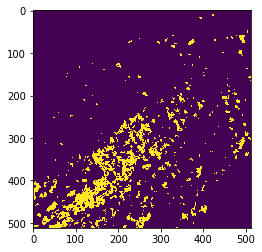

In [73]:
plt.imshow(asoTile.read().squeeze())


In [74]:
aso_resamp = ndimage.zoom(asoTile.read().squeeze(), zoom=0.5, order = 2)


In [75]:
metrics.f1_score(aso_pix, pred_pix)

0.438003120124805

In [76]:
metrics.f1_score(aso_resamp.flatten(), p_t_resamp.flatten())

0.4399098647971958

In [56]:
((aso_resamp.flatten() == 1) | (aso_resamp.flatten() == 0)).all()

True

In [67]:
((p_t[1].numpy().flatten() == 1) | (p_t[1].numpy().flatten() == 0)).all()

True

In [69]:
p_t_resamp

array([[-0.00000000e+00,  0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.95954236e-42,  9.95905296e-29,  6.80944194e-27, ...,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [-3.12489558e-43,  1.45654715e-30,  9.95905296e-29, ...,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [ 2.80259693e-45, -4.48415509e-44,  1.43492963e-42, ...,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00]], dtype=float32)

In [71]:
p_t[1].numpy().dtype

dtype('float32')

In [ ]:
FPs

## Merge and F1

In [8]:
def download_s3url(url, directory, s3):
    parsed = url[5:].split('/')
    bucket = parsed[0]
    key = os.path.join(*parsed[1:])
    slug = "-".join(parsed[1:])
    s3.download_file(bucket, key, os.path.join(directory, slug))

In [42]:
def stack_and_mask(workdir, asodir, preddir):

    ! /bin/bash -c "echo 'Merge vrts' && source activate gdal && gdalbuildvrt -separate $workdir/stack.vrt $asodir/merged-aso.tif $preddir/merged-pred.tif"
    stack = rio.open(os.path.join(workdir, "stack.vrt"))
    mask = gpd.read_file(os.path.join(workdir, "data-mask.geojson"))
    stack_masked = rio.mask.mask(stack, mask.geometry.values, nodata = -1)

    return stack_masked
    

In [54]:
def compute_performance(workdir, stack_masked):

    aso_all = stack_masked[0][0].flatten()
    aso_all = aso_all[~(aso_all == -1)]

    pred_all = stack_masked[0][1].flatten()
    pred_all = pred_all[~(pred_all == -1)]

    performance = metrics.precision_recall_fscore_support(aso_all, pred_all, average = 'binary')
    return(performance)

In [52]:
def plotall(workdir, stack, image, performance):
    imagedata = rio.open(image)
    fig, ax = plt.subplots(nrows=3, figsize=(8.5, 11))
    ax[0].set_title("ASO")
    show(stack[0][0], with_bounds = True, transform = stack[1], ax=ax[0], vmin = 0, cmap='Reds')
    ax[1].set_title("ML Prediction - acc: {:.2f} rec: {:.2f} f:{:.2f} ".format(performance[0], performance[1], performance[2]))
    show(stack[0][1], with_bounds = True, transform = stack[1], ax = ax[1], vmin = 0, cmap='Blues')
    show(imagedata.read(1), with_bounds=True, ax = ax[2], transform = imagedata.transform )
    ax[2].set_title("NIR")
    show(imagedata.read(1), with_bounds=True, ax = ax[2], transform = imagedata.transform, cmap='binary')
    ax[2].set_xlim(ax[0].get_xlim())
    ax[2].set_ylim(ax[0].get_ylim())
    plt.savefig(os.path.join(workdir, "summary.pdf"))
    plt.show()

100%|██████████| 4/4 [00:00<00:00,  9.63it/s]


Merge ASO
0...10...20...30...40...50...60...70...80...90...100 - done.
Merge Pred
0...10...20...30...40...50...60...70...80...90...100 - done.
Merge vrts
0...10...20...30...40...50...60...70...80...90...100 - done.
download: s3://planet-snowcover-imagery/planet-orders/368c44b6-1d9e-4fc6-9131-bd5f0ec23655/21/files/20180528_180846_1002_3B_AnalyticMS_SR_clip.tif to ../../../../tmp/20180528_180846_1002_3B_AnalyticMS_SR_clip4doyb2hc/image.tif
Creating output file that is 1294P x 4707L.
Processing /tmp/20180528_180846_1002_3B_AnalyticMS_SR_clip4doyb2hc/image.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /tmp/20180528_180846_1002_3B_AnalyticMS_SR_clip4doyb2hc/image.tif.
Copying nodata values from source /tmp/20180528_180846_1002_3B_AnalyticMS_SR_clip4doyb2hc/image.tif to destination /tmp/20180528_180846_1002_3B_AnalyticMS_SR_clip4doyb2hc/image_reproj_4326.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.


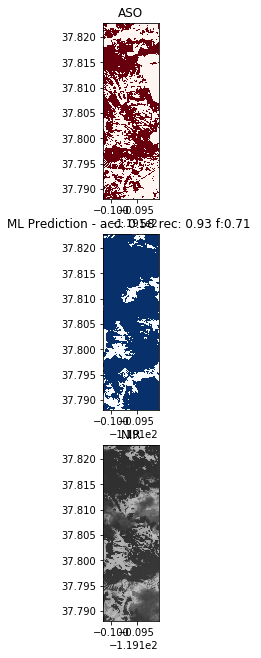

100%|██████████| 1/1 [00:00<00:00,  6.40it/s]


Merge ASO
0...10...20...30...40...50...60...70...80...90...100 - done.
Merge Pred
0...10...20...30...40...50...60...70...80...90...100 - done.
Merge vrts
0...10...20...30...40...50...60...70...80...90...100 - done.
download: s3://planet-snowcover-imagery/planet-orders/368c44b6-1d9e-4fc6-9131-bd5f0ec23655/7/files/20180528_180847_1002_3B_AnalyticMS_SR_clip.tif to ../../../../tmp/20180528_180847_1002_3B_AnalyticMS_SR_clipfeau98g0/image.tif
Creating output file that is 1779P x 2627L.
Processing /tmp/20180528_180847_1002_3B_AnalyticMS_SR_clipfeau98g0/image.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /tmp/20180528_180847_1002_3B_AnalyticMS_SR_clipfeau98g0/image.tif.
Copying nodata values from source /tmp/20180528_180847_1002_3B_AnalyticMS_SR_clipfeau98g0/image.tif to destination /tmp/20180528_180847_1002_3B_AnalyticMS_SR_clipfeau98g0/image_reproj_4326.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.


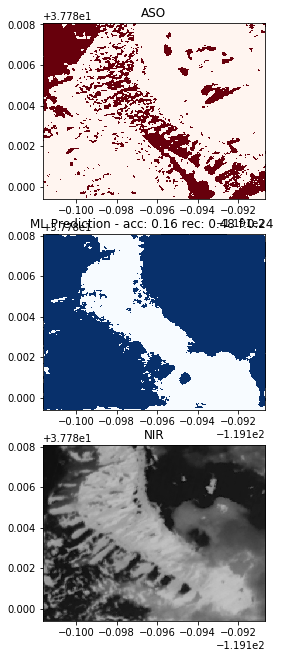

FAIL: No tiles in 20180528_181107_1025_3B_AnalyticMS_SR_clip


100%|██████████| 24/24 [00:03<00:00,  6.11it/s]


Merge ASO
0...10...20...30...40...50...60...70...80...90...100 - done.
Merge Pred
0...10...20...30...40...50...60...70...80...90...100 - done.
Merge vrts
0...10...20...30...40...50...60...70...80...90...100 - done.
download: s3://planet-snowcover-imagery/planet-orders/368c44b6-1d9e-4fc6-9131-bd5f0ec23655/1/files/20180528_181108_1025_3B_AnalyticMS_SR_clip.tif to ../../../../tmp/20180528_181108_1025_3B_AnalyticMS_SR_clipzbu7zmjm/image.tif
Creating output file that is 9310P x 3262L.
Processing /tmp/20180528_181108_1025_3B_AnalyticMS_SR_clipzbu7zmjm/image.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /tmp/20180528_181108_1025_3B_AnalyticMS_SR_clipzbu7zmjm/image.tif.
Copying nodata values from source /tmp/20180528_181108_1025_3B_AnalyticMS_SR_clipzbu7zmjm/image.tif to destination /tmp/20180528_181108_1025_3B_AnalyticMS_SR_clipzbu7zmjm/image_reproj_4326.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.


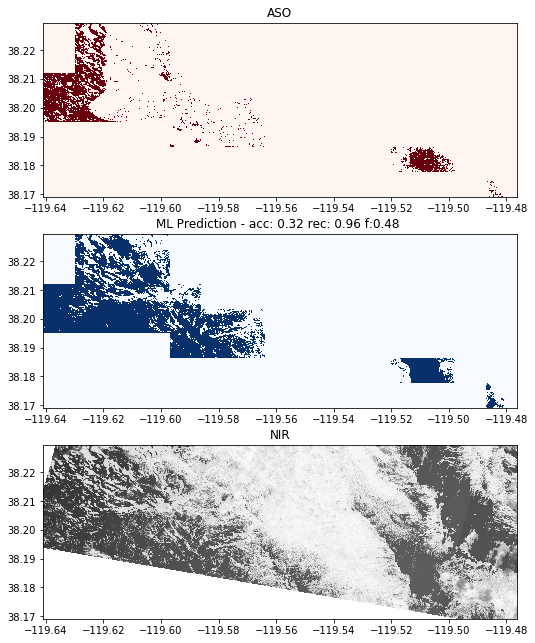

100%|██████████| 153/153 [00:23<00:00,  6.49it/s]


Merge ASO
0...10...20...30...40...50...60...70...80...90...100 - done.
Merge Pred
0...10...20...30...40...50...60...70...80...90...100 - done.
Merge vrts
0...10...20...30...40...50...60...70...80...90...100 - done.
download: s3://planet-snowcover-imagery/planet-orders/368c44b6-1d9e-4fc6-9131-bd5f0ec23655/5/files/20180528_181109_1025_3B_AnalyticMS_SR_clip.tif to ../../../../tmp/20180528_181109_1025_3B_AnalyticMS_SR_clip_fvcfy77/image.tif
Creating output file that is 9409P x 4069L.
Processing /tmp/20180528_181109_1025_3B_AnalyticMS_SR_clip_fvcfy77/image.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /tmp/20180528_181109_1025_3B_AnalyticMS_SR_clip_fvcfy77/image.tif.
Copying nodata values from source /tmp/20180528_181109_1025_3B_AnalyticMS_SR_clip_fvcfy77/image.tif to destination /tmp/20180528_181109_1025_3B_AnalyticMS_SR_clip_fvcfy77/image_reproj_4326.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.


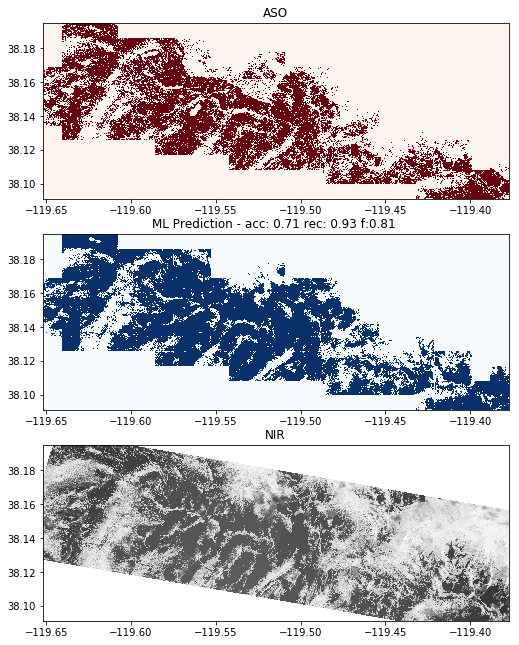

In [58]:
s3 = aws_session.client("s3")
dirs = []
for pred_loc in predictions[:5]:
    aso = datasets.S3SlippyMapTiles("s3://planet-snowcover-snow/ASO_3M_SD_USCATE_20180528_binary", 'multibands', aws_profile='esip').tiles
    pred = datasets.S3SlippyMapTiles("s3://planet-snowcover-predictions/"+pred_loc, 'multibands', aws_profile='esip', ext='tif').tiles ## only TIF predictions wanted here.
    image = datasets.S3SlippyMapTiles("s3://planet-snowcover-imagery/"+pred_loc, 'multibands', aws_profile='esip').tiles

    aso_ids, aso_tiles, aso_paths = zip(*aso)
    pred_ids, pred_tiles, pred_paths = zip(*pred)
    
    tile_overlap = set(aso_tiles).intersection(set(pred_tiles))
    
    if(len(tile_overlap) == 0): 
        print("FAIL: No tiles in {}".format(pred_loc))
        continue
    
    aso = [_ for _ in aso if _[1] in tile_overlap]
    pred = [_ for _ in pred if _[1] in tile_overlap]
    image = [_ for _ in image if _[1] in tile_overlap]
    
    # create dir
    tmpdir = mkdtemp(prefix=pred_loc)
    dirs.append(tmpdir)
    asodir = os.path.join(tmpdir, "ASO")
    os.mkdir(asodir)
    preddir = os.path.join(tmpdir, "preds")
    os.mkdir(preddir)
    
    # create tile masks
    pred_mask = ops.cascaded_union([geometry.Polygon.from_bounds(*mercantile.bounds(t_i)) for t_i in tile_overlap])
    with open(os.path.join(tmpdir, "data-mask.geojson"), 'w') as f:
        f.write((json.dumps(geometry.mapping(pred_mask))))


    
    for p_t, i_t in tqdm(zip(pred, image), total = len(tile_overlap)):
        tile = p_t[1]
        asoTileLoc = "s3://planet-snowcover-snow/{}/{}/{}/{}.tif".format("ASO_3M_SD_USCATE_20180528_binary", tile.z, tile.x, tile.y)

        try: 
            download_s3url(p_t[2], preddir, s3)
        except Exception as e:
            print("Download failed {}".format(p_t[2]))
        try: 
            download_s3url(asoTileLoc, asodir, s3)
        except Exception as e:
            print("Download failed {}".format(asoTileLoc))
            
    # merge to one ASO raster
    ! /bin/bash -c "echo 'Merge ASO' && source activate gdal && (gdal_merge.py -ot 'Int16' -co 'COMPRESS=LZW' -o $asodir/merged-aso.tif $(find $asodir -name '*.tif' -printf '%p '))"    
    ! /bin/bash -c "echo 'Merge Pred' &&source activate gdal && (gdal_merge.py -ot 'Int16' -co 'COMPRESS=LZW' -o $preddir/merged-pred.tif $(find $preddir -name '*.tif' -printf '%p '))"    
#     ! /bin/bash -c "echo 'Merge Pred (vrt)' && source activate gdal && (gdalbuildvrt $preddir/merged-pred.vrt $(find $preddir -name '*-*.tif' -printf '%p '))"
#     ! /bin/bash -c "echo 'Merge ASO (vrt)' && source activate gdal && (gdalbuildvrt $asodir/merged-aso.vrt $(find $asodir -name '*-*.tif' -printf '%p '))"
        
    stack_masked = stack_and_mask(tmpdir, asodir, preddir)
    performance = compute_performance(tmpdir, stack_masked)
    
    # get image for plottin 
    imagepath = fs.glob("planet-snowcover-imagery/planet-orders/*/*/files/{}.tif".format(pred_loc))[0]
    ! aws s3 cp --profile 'esip' s3://$imagepath $tmpdir/image.tif
    ! /bin/bash -c "source activate gdal && gdalwarp -t_srs 'EPSG:4326'  $tmpdir/image.tif $tmpdir/image_reproj_4326.vrt"
    
    plotall(tmpdir, stack_masked, os.path.join(tmpdir, 'image_reproj_4326.vrt'), performance)
    cleanup(tmpdir)


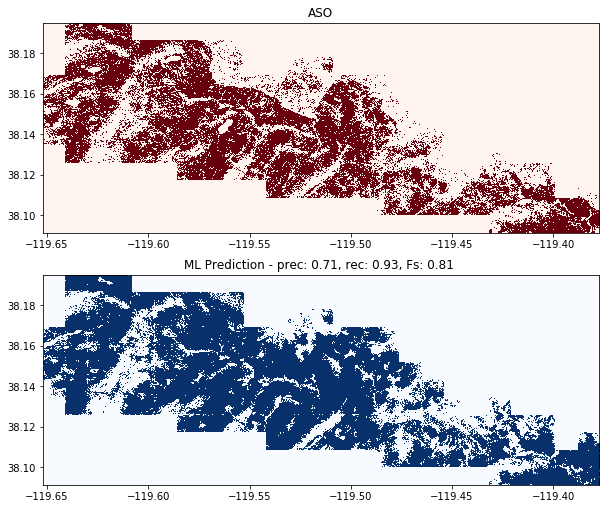

In [25]:

fig, ax = plt.subplots(nrows=2, figsize=(11, 8.5))
ax[0].set_title("ASO")
show(stack_masked[0][0], with_bounds = True, transform = stack_masked[1], ax=ax[0], vmin = 0, cmap='Reds')
ax[1].set_title("ML Prediction - prec: {:.2f}, rec: {:.2f}, Fs: {:.2f} ".format(performance[0], performance[1], performance[2]))
show(stack_masked[0][1], with_bounds = True, transform = stack_masked[1], ax = ax[1], vmin = 0, cmap='Blues')
# show(imagedata.read(1), with_bounds=True, ax = ax[2], transform = imagedata.transform )
# ax[2].set_title("NIR")
# show(imagedata.read(1), with_bounds=True, ax = ax[2], transform = imagedata.transform, cmap='binary')
# ax[2].set_xlim(ax[0].get_xlim())
# ax[2].set_ylim(ax[0].get_ylim())
plt.savefig(os.path.join(tmpdir, "summary.pdf"))

In [10]:
imagepath = fs.glob("planet-snowcover-imagery/planet-orders/*/*/files/{}.tif".format(pred_loc))[0]


In [11]:
! aws s3 cp --profile 'esip' s3://$imagepath $tmpdir/image.tif

download: s3://planet-snowcover-imagery/planet-orders/368c44b6-1d9e-4fc6-9131-bd5f0ec23655/5/files/20180528_181109_1025_3B_AnalyticMS_SR_clip.tif to ../../../../tmp/20180528_181109_1025_3B_AnalyticMS_SR_clipazdzc5yu/image.tif


In [33]:
def cleanup(topdir):
    rawtif = glob(os.path.join(topdir, "*", "-*.tif"))

    for file in rawtif:
        os.remove(file)
    

In [32]:
cleanup(tmpdir)

In [34]:
imagepath = fs.glob("planet-snowcover-imagery/planet-orders/*/*/files/{}.tif".format(pred_loc))[0]
! aws s3 cp --profile 'esip' s3://$imagepath $tmpdir/image.tif
! /bin/bash -c "source activate gdal && gdalwarp -t_srs 'EPSG:4326'  $tmpdir/image.tif $tmpdir/image_reproj_4326.vrt"

download: s3://planet-snowcover-imagery/planet-orders/368c44b6-1d9e-4fc6-9131-bd5f0ec23655/5/files/20180528_181109_1025_3B_AnalyticMS_SR_clip.tif to ../../../../tmp/20180528_181109_1025_3B_AnalyticMS_SR_clipnav_2x0q/image.tif
Creating output file that is 9409P x 4069L.
Processing /tmp/20180528_181109_1025_3B_AnalyticMS_SR_clipnav_2x0q/image.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /tmp/20180528_181109_1025_3B_AnalyticMS_SR_clipnav_2x0q/image.tif.
Copying nodata values from source /tmp/20180528_181109_1025_3B_AnalyticMS_SR_clipnav_2x0q/image.tif to destination /tmp/20180528_181109_1025_3B_AnalyticMS_SR_clipnav_2x0q/image_reproj_4326.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.


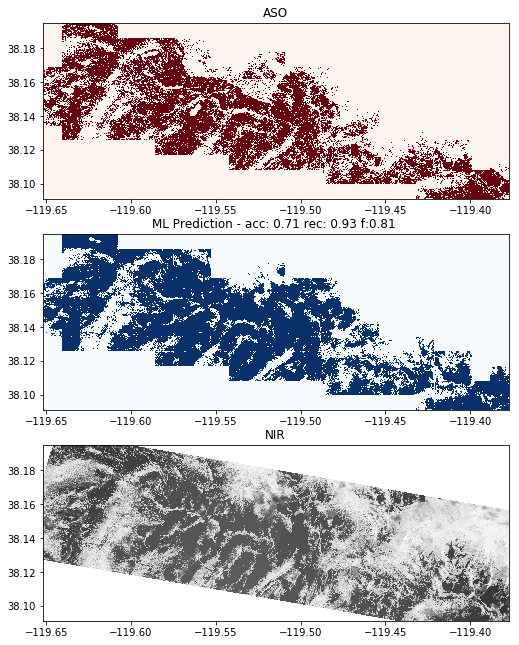

In [37]:
imagedata = rio.open(os.path.join(d, "image_reproj_4326.vrt") )

fig, ax = plt.subplots(nrows=3, figsize=(8.5, 11))
ax[0].set_title("ASO")
show(stack_masked[0][0], with_bounds = True, transform = stack_masked[1], ax=ax[0], vmin = 0, cmap='Reds')
ax[1].set_title("ML Prediction - acc: {:.2f} rec: {:.2f} f:{:.2f} ".format(performance[0], performance[1], performance[2]))
show(stack_masked[0][1], with_bounds = True, transform = stack_masked[1], ax = ax[1], vmin = 0, cmap='Blues')
show(imagedata.read(1), with_bounds=True, ax = ax[2], transform = imagedata.transform )
ax[2].set_title("NIR")
show(imagedata.read(1), with_bounds=True, ax = ax[2], transform = imagedata.transform, cmap='binary')
ax[2].set_xlim(ax[0].get_xlim())
ax[2].set_ylim(ax[0].get_ylim())
plt.savefig(os.path.join(tmpdir, "summary.pdf"))

In [74]:
# rescaled = np.stack([
#     skimage.exposure.equalize_adapthist(imagedata.read(3)/10000), 
#     skimage.exposure.equalize_adapthist(imagedata.read(1)/10000),
#     skimage.exposure.equalize_adapthist(imagedata.read(2)/10000)])

rescaled = skimage.exposure.rescale_intensity(imagedata.read([3,1,2]), in_range = (0, .62))


MemoryError: 

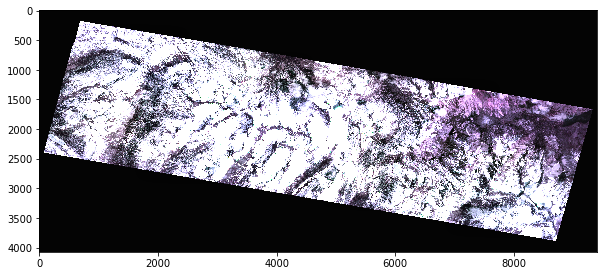

In [71]:
fig = plt.figure(figsize=(10,10))
show(rescaled)

In [38]:
print(metrics.classification_report(aso_all, pred_all))

'              precision    recall  f1-score   support\n\n           0       0.87      0.56      0.68  18520930\n           1       0.71      0.93      0.81  21585566\n\n   micro avg       0.76      0.76      0.76  40106496\n   macro avg       0.79      0.75      0.74  40106496\nweighted avg       0.79      0.76      0.75  40106496\n'

In [40]:
metrics.precision_recall_fscore_support(aso_all, pred_all, average = 'binary')

(0.7120741267422607, 0.927871662017109, 0.8057746883932757, None)

In [39]:
a = "'              precision    recall  f1-score   support\n\n           0       0.87      0.56      0.68  18520930\n           1       0.71      0.93      0.81  21585566\n\n   micro avg       0.76      0.76      0.76  40106496\n   macro avg       0.79      0.75      0.74  40106496\nweighted avg       0.79      0.76      0.75  40106496\n'"
print(a)

'              precision    recall  f1-score   support

           0       0.87      0.56      0.68  18520930
           1       0.71      0.93      0.81  21585566

   micro avg       0.76      0.76      0.76  40106496
   macro avg       0.79      0.75      0.74  40106496
weighted avg       0.79      0.76      0.75  40106496
'


In [87]:
both_merged[0].shape

(1, 6142, 12800)

In [1]:
%%bash -s "$asodir"
source activate gdal && gdal_merge.py -co 'COMPRESS=LZW' -o ${1}/merged-aso.tif $(find ${1} -name '*.tif')


No input files selected.
Usage: gdal_merge.py [-o out_filename] [-of out_format] [-co NAME=VALUE]*
                     [-ps pixelsize_x pixelsize_y] [-tap] [-separate] [-q] [-v] [-pct]
                     [-ul_lr ulx uly lrx lry] [-init "value [value...]"]
                     [-n nodata_value] [-a_nodata output_nodata_value]
                     [-ot datatype] [-createonly] input_files
                     [--help-general]



find: ‘$asodir’: No such file or directory


In [47]:
"-".join("s3://planet-snowcover-predictions/20180528_180846_1002_3B_AnalyticMS_SR_clip/15/5534/12660.tif"[5:].split('/')[1:])

'20180528_180846_1002_3B_AnalyticMS_SR_clip-15-5534-12660.tif'

In [93]:
stack.stack()

In [18]:
rio.open(tmpdir+"/stack.vrt").read(2).shape

(6144, 12800)

In [19]:
rio.open(tmpdir+"/stack.vrt").read(1).shape

(6144, 12800)

In [48]:
images =  [d.split('/')[1] for d in fs.ls('planet-snowcover-imagery/planet-orders') if re.match(".*20180528.*_clip", d)]

In [71]:
with rio.Env(session = aws_session):
    print(rio.open("s3://" + fs.glob("planet-snowcover-imagery/planet-orders/*/*/files/{}.tif".format(pred_loc))[0]).count)

/home/ubuntu/anaconda3/envs/pytorch_p36_2/lib/python3.6/site-packages/rasterio/env.py:180: RasterioDeprecationWarning: Passing a boto3 session is deprecated. Pass a Rasterio AWSSession object instead.
  RasterioDeprecationWarning


RasterioIOError: '/vsis3/planet-snowcover-imagery/planet-orders/368c44b6-1d9e-4fc6-9131-bd5f0ec23655/5/files/20180528_181109_1025_3B_AnalyticMS_SR_clip.tif' does not exist in the file system, and is not recognized as a supported dataset name.

In [65]:
images

'20180528_181109_1025_3B_AnalyticMS_SR_clip'

In [10]:
with rio.Env(profile_name = 'esip'):
    rio.open("s3://planet-snowcover-imagery/planet-orders/368c44b6-1d9e-4fc6-9131-bd5f0ec23655/5/files/20180528_181109_1025_3B_AnalyticMS_SR_clip.tif")
    
    